Poniższa analiza danych dotyczy katastrofy statku Titanic, która miała miejsce w 1912 roku. Chcemy zbudować model klasyfikacyjny, który na podstawie dostępnych informacji o części pasażerów będzie odgadywać, czy dany pasażer statku Titanic przeżył katastrofę. Do dyspozycji mamy następujące parametry pasażera:  

* PassengerId - liczba porządkowa przypisana każdemu pasażerowi. 

* Survived - liczba określająca przeżycie pasażera. Wartość 0 oznacza śmierć osoby, a 1 przypisano ocalałym. 

* Pclass - numer klasy podróży, jaką wykupił sobie pasażer. 

* Name - nazwisko, tytuł (forma grzecznościowa) oraz imiona pasażera. 

* Sex - płeć pasażera: female - kobieta, male - mężczyzna. 

* Age - wiek pasażera w latach. 

* SibSp - liczba rodzeństwa/małżonków pasażera na statku. 

* Parch - liczba rodziców/dzieci pasażera na statku. 

* Ticket - identyfikator biletu pasażera. Bilety grupowe posiadają identyczne identyfikatory. 

* Fare - opłata za bilet. Dla biletów grupowych jest to kwota łączna za wszystkie osoby. 

* Cabin - identyfikator kabiny przypisanej pasażerowi. 

* Embarked - miejsce rozpoczęcia rejsu przez pasażera. Kodowanie: S - Southampton, C - Cherbourg, Q - Queenstown. 

Problematyka i dane zostały zaczerpnięte z jednego z wyzwań z portalu internetowego kaggle.com - "Titanic - Machine Learning from Disaster". 

In [1]:
import numpy as np 
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dane=pd.read_csv('../input/titanic/train.csv')

In [3]:
dane=pd.read_csv('train.csv')

# Wstępny przegląd danych

Analizę zaczniemy od spojrzenia na kompletność otrzymanego zbioru danych. Następnie obejrzymy każdą zmienną pod kątem niepoprawnych wpisów.

In [4]:
braki_danych = [col for col in dane.columns
                     if dane[col].isnull().any()]
print(braki_danych)

['Age', 'Cabin', 'Embarked']


In [5]:
dane.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Z powyższych wyników widzimy, że mamy 3 zmienne z brakującymi danymi: 'Age', 'Cabin' i 'Embarked'. Przystąpimy teraz do przeglądu każdej zmiennej liczbowej z osobna. 

In [6]:
dane.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Ze statystyk opisowych zmiennych liczbowych możemy wywnioskować kilka informacji. W naszym dostępnym zbiorze danych przeżyło tylko 38% wszystkich pasażerów. Żaden z zakresów danych nie wygląda podejrzanie - minima są niemniejsze od 0, a maksima mieszczą się w granicach zdrowego rozsądku. 
Spójrzmy teraz na zmienne, które mają w sobie braki.

In [7]:
dane['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Zmienna 'Embarked' posiada 2 braki. Przy tak dużej przewadze wartości "S" nad pozostałymi oraz przy tak niewielkiej liczbie braków można uznać, że przypisanie brakom najczęstszej wartości jest sensowne.

In [8]:
dane.loc[dane['Embarked'].isnull()==1,'Embarked']='S'

In [9]:
dane['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
E101           3
C22 C26        3
              ..
D6             1
B86            1
F G63          1
B80            1
A10            1
Name: Cabin, Length: 147, dtype: int64

Z samego podglądu danych dotyczących kabin możemy zauważyć, że jest 147 unikalnych wartości. Drugim spostrzeżeniem jest występowanie osób, którym przypisano więcej niż jedną kabinę. Wygląda na to, że dana zmienna nie będzie mogła być wykorzystana, gdyż ma więcej niż 50% brakujących wartości, które nie są łatwe do uzupełnienia. Metody predykcji numeru kabiny nie wydają się tutaj odpowiednie, ponieważ niektórzy pasażerowie byli pracownikami statku i mogli nie mieć przypisanego im miejsca. Uzupełnianie tak dużych i nietrywialnych braków stwarza bardzo duże ryzyko wnioskowania na podstawie zmiennej niemającej związku z opisywaną rzeczywistością. 

Pozostałe zmienne również zostały sprawdzone, lecz nie jest to na tyle warte, by to tu jawnie przedstawić. 

# Tworzenie nowych zmiennych (feature engineering)

Pierwszą tworzoną zmienną, która później okaże się przydatna, jest tytuł/forma grzecznościowa pasażera. Należy tutaj zaznaczyć, że zmienna 'Name' posiada w sobie zawsze cząstkę tej formy, niezależnie od wieku i płci pasażera. Należy również zauważyć, że każda z tych form grzecznościowych ma po sobie kropkę. Wykorzystamy ten fakt i dokonamy sprytnego podziału tekstu. Poniższe sprawdzenie pokazuje, że jest jednak jedna osoba, która ma w zmiennej 'Name' więcej niż jedną kropkę.

In [10]:
dane['Name'].str.count('\.').sort_values()

0      1
587    1
588    1
589    1
590    1
      ..
302    1
303    1
292    1
890    1
513    2
Name: Name, Length: 891, dtype: int64

In [11]:
dane.iloc[513]

PassengerId                                               514
Survived                                                    1
Pclass                                                      1
Name           Rothschild, Mrs. Martin (Elizabeth L. Barrett)
Sex                                                    female
Age                                                        54
SibSp                                                       1
Parch                                                       0
Ticket                                               PC 17603
Fare                                                     59.4
Cabin                                                     NaN
Embarked                                                    C
Name: 513, dtype: object

Jeden przypadek można zawsze łatwo dostosować do naszych potrzeb, edytując problematyczną wartość. Mówiąc ściślej, usuniemy kropkę w skrócie "L.". 

In [12]:
dane.loc[dane.Name=='Rothschild, Mrs. Martin (Elizabeth L. Barrett)','Name']='Rothschild, Mrs. Martin (Elizabeth L Barrett)'

In [13]:
kolumna_tytuly=[]
for osoba in dane['Name']:
    for slowo in osoba.split():
        if '.' in slowo:
            kolumna_tytuly.append(slowo)

In [14]:
dane['Title']=kolumna_tytuly

Możemy teraz przyjrzeć się wszystkim pojawiającym się tytułom w zbiorze. Warto odnotować, że 'Mr.' i 'Master.' odnoszą się do mężczyzn bez podkreślenia pochodzenia szlacheckiego, gdzie 'Master.' przypada głównie dzieciom. Podobna sytuacja jest z kobietami, tutaj brak tytułu szlacheckiego oznacza pojawienie się zwrotów 'Mrs.', 'Miss.' i 'Ms.'. Warto zwrócić uwagę jeszcze na obecność księży na pokładzie - oznaczeni są oni tytułem 'Rev.'. 

In [15]:
dane.Title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

Następną ciekawą informacją będzie poznanie wartości biletu na jedną osobę. Można by zastanawiać się nad hipotezą, czy osoby bogatsze miały większe możliwości uratowania się ze statku. Wysoka cena biletu wydaje się tracić na znaczeniu, gdy korzysta z niego kilka osób. 

In [16]:
liczba_biletow=dane.groupby(by=['Ticket']).size()
bilety=pd.DataFrame(liczba_biletow,columns=["liczba"])

In [17]:
dane=pd.merge(dane, bilety, on=["Ticket", "Ticket"])
dane['FareN']=dane['Fare']/dane['liczba']

Na koniec stworzymy jeszcze jedną zmienną, która określi liczbę osób z rodziny pasażera na statku.

In [18]:
dane['Family']=dane['SibSp']+dane['Parch']

Usuniemy jeszcze kłopotliwą zmienną dotyczącą kabin wraz z inną kolumną pomocniczą.

In [19]:
dane.drop(['liczba','Cabin'], axis=1, inplace=True)

# Podział na zbiór treningowy i testowy

Podział ten będzie w stosunku 8:2, gdzie większą część zajmie zbiór treningowy. Stosować będziemy tutaj kroswalidację, więc nie będziemy rozważać osobnego zbioru walidacyjnego.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dane, dane.Survived, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=42)


In [21]:
del dane

# Przegląd zbioru treningowego 


Przyjrzymy się teraz dokładniej naszym danym w zbiorze treningowym. Pomijamy przy tym zbiór testowy w celu uniknięcia wycieku informacji. Pierwszym problemem, którym musimy się zająć, są braki danych w kolumnie związanej z wiekiem pasażera. W tym celu posłużymy się kilkoma statystykami opisowymi w podziale na tytuł/formę grzecznościową. 

In [22]:
X_train[['Age','Title']].groupby('Title').agg(['min','mean','median','max'])

Age                        
             min       mean median   max
Title                                   
Capt.      70.00  70.000000   70.0  70.0
Col.       60.00  60.000000   60.0  60.0
Countess.  33.00  33.000000   33.0  33.0
Dr.        23.00  42.000000   46.5  54.0
Major.     45.00  48.500000   48.5  52.0
Master.     0.42   4.358148    3.0  12.0
Miss.       0.75  22.152893   22.0  63.0
Mlle.      24.00  24.000000   24.0  24.0
Mme.       24.00  24.000000   24.0  24.0
Mr.        14.00  32.523659   30.0  74.0
Mrs.       14.00  35.857143   35.0  60.0
Ms.        28.00  28.000000   28.0  28.0
Rev.       27.00  37.000000   35.0  51.0
Sir.       49.00  49.000000   49.0  49.0

W wypisanych powyżej wyników widzimy, że średnie i mediany raczej nie różnią się od siebie w sposób znaczący. Uzupełnimy braki w zmiennej 'Age' biorąc medianę z danej grupy wyznaczonej przez 'Title'. 

In [23]:
braki_wiek=[round(X_train[(X_train['Age'].isnull()==0)&(X_train['Name'].str.contains('Master.', na=False)==1)].Age.median(),0)
,round(X_train[(X_train['Age'].isnull()==0)&(X_train['Name'].str.contains('Miss.', na=False)==1)].Age.median(),0)
,round(X_train[(X_train['Age'].isnull()==0)&(X_train['Name'].str.contains('Mrs.', na=False)==1)].Age.median(),0)
,round(X_train[(X_train['Age'].isnull()==0)&(X_train['Name'].str.contains('Mr.', na=False)==1)].Age.median(),0)
,round(X_train[(X_train['Age'].isnull()==0)&(X_train['Name'].str.contains('Dr.', na=False)==1)].Age.median(),0)]
pd.DataFrame(braki_wiek,columns=["mediana grupy"]).set_index([['Master.','Miss.', 'Mrs.','Mr.','Dr.']])


,mediana grupy
Master.,3.0
Miss.,22.0
Mrs.,35.0
Mr.,31.0
Dr.,44.0


In [24]:
X_train.loc[(X_train['Age'].isnull()==1)&(X_train['Name'].str.contains('Master.', na=False)==1),'Age']=braki_wiek[0]
X_train.loc[(X_train['Age'].isnull()==1)&(X_train['Name'].str.contains('Miss.', na=False)==1),'Age']=braki_wiek[1]
X_train.loc[(X_train['Age'].isnull()==1)&(X_train['Name'].str.contains('Mrs.', na=False)==1),'Age']=braki_wiek[2]
X_train.loc[(X_train['Age'].isnull()==1)&(X_train['Name'].str.contains('Mr.', na=False)==1),'Age']=braki_wiek[3]
X_train.loc[(X_train['Age'].isnull()==1)&(X_train['Name'].str.contains('Dr.', na=False)==1),'Age']=braki_wiek[4]

Uzupełnimy też od razu braki w zbiorze testowym - wartościami wziętymi ze zbioru treningowego.

In [25]:
X_test.loc[(X_test['Age'].isnull()==1)&(X_test['Name'].str.contains('Master.', na=False)==1),'Age']=braki_wiek[0]
X_test.loc[(X_test['Age'].isnull()==1)&(X_test['Name'].str.contains('Miss.', na=False)==1),'Age']=braki_wiek[1]
X_test.loc[(X_test['Age'].isnull()==1)&(X_test['Name'].str.contains('Mrs.', na=False)==1),'Age']=braki_wiek[2]
X_test.loc[(X_test['Age'].isnull()==1)&(X_test['Name'].str.contains('Mr.', na=False)==1),'Age']=braki_wiek[3]
X_test.loc[(X_test['Age'].isnull()==1)&(X_test['Name'].str.contains('Dr.', na=False)==1),'Age']=braki_wiek[4]

Mając uzupełnione dane, przejdźmy teraz do zwizualizowania części informacji.

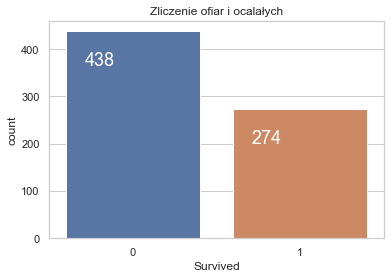

In [26]:
ax=sns.countplot(x=X_train.Survived);
ax.set_title('Zliczenie ofiar i ocalałych')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.show()

Ze zbioru treningowego liczącego 712 obserwacji tylko 274 osoby przeżyło katastrofę. Ocaleni stanowią 38.5%, czyli w przybliżeniu na trzech pasażerów przeżyła tylko jedna osoba.

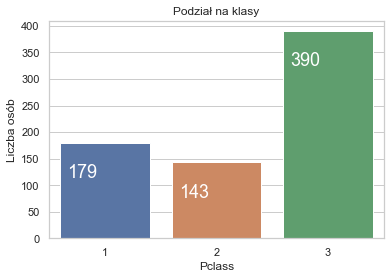

In [27]:
ax=sns.countplot(x=X_train.Pclass);
ax.set_title('Podział na klasy')
ax.set(ylabel="Liczba osób")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.show()

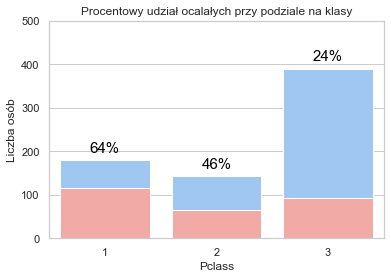

In [28]:
przezycie_od_klasy=X_train[['Survived','Pclass']].groupby('Pclass').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_klasy.index, y=przezycie_od_klasy.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 500))
ax.set_title('Procentowy udział ocalałych przy podziale na klasy')
i=0
for p in ax.patches:
    procent=przezycie_od_klasy['Survived'].iloc[i,0]/przezycie_od_klasy['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+80), ha='center', va='top', color='black', size=15)
    i=i+1
ax = sns.barplot(x=przezycie_od_klasy.index, y=przezycie_od_klasy.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

Pasażerowie mieli do wyboru 3 klasy, gdzie klasa o numerze "3" była najtańsza oraz najbradziej liczna. Stanowi ona 54% wszystkich. Klasa druga, najmniej liczna ze wszystkich, stanowi 20% populacji zbioru treningowego. Na drugim wykresie liczba przedstawiona nad słupkiem oznacza procent osób, które przeżyły katastrofę w danej grupie. Liczba ta wyrażona jest kolorem różowym na wykresie. Widzimy zatem, że wyższa klasa (niższy numer) dawała większą szansę na uratowanie się.

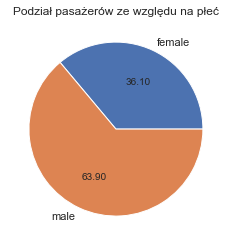

In [29]:
X_train.groupby('Sex').size().plot(kind='pie', autopct='%.2f',title='Podział pasażerów ze względu na płeć',ylabel='');

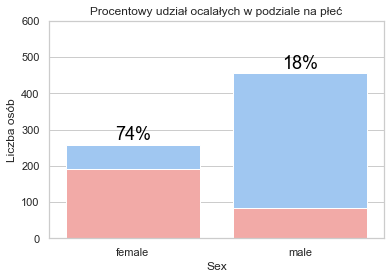

In [30]:
przezycie_od_plci=X_train[['Survived','Sex']].groupby('Sex').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_plci.index, y=przezycie_od_plci.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 600))
ax.set_title('Procentowy udział ocalałych w podziale na płeć')
i=0
for p in ax.patches:
    procent=przezycie_od_plci['Survived'].iloc[i,0]/przezycie_od_plci['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+110), ha='center', va='top', color='black', size=18)
    i=i+1
ax = sns.barplot(x=przezycie_od_plci.index, y=przezycie_od_plci.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

Wykres kołowy pokazuje, że prawie dwie trzecie pasażerów stanowili mężczyźni. Wykres słupkowy zdradza drugą ciekawą informację - co czwarta kobieta zginęła oraz tylko co piąty mężczyzna przetrwał. Ta poważna dysproporcja wzięła się najpewniej z zasadny "Najpierw kobiety i dzieci" i może ona spowodować przeuczanie się modelu predykcyjnego. 

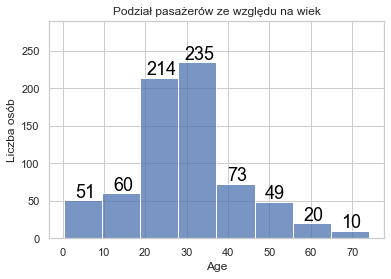

In [31]:
ax=sns.histplot(x=X_train.Age,bins=8)
ax.set(ylim=(0, 290))
ax.set_title('Podział pasażerów ze względu na wiek')
ax.set(ylabel="Liczba osób")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+5, p.get_height()+50), ha='center', va='top', color='black', size=18)
plt.show()

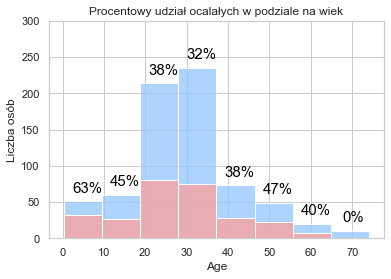

In [32]:
licznik=[]
i=0
bins = np.histogram_bin_edges(X_train['Age'], bins=8)
ax = plt.subplots()
ax=sns.histplot(x=X_train.Age,bins=bins, color="#92C6FF")
ax.set(ylim=(0, 300))
ax.set_title('Procentowy udział ocalałych w podziale na wiek')
ax.set(ylabel="Liczba osób")  
ax=sns.histplot(x=X_train[X_train['Survived']==1]['Age'],bins=bins, color="#FF9F9A")  
#Zbiera wysokosci slupkow - najpierw wszystkich pasazerow wedlug grup, a nastepnie tylko ocalalych tez grupowo
for p in ax.patches:
    licznik.append(p.get_height()) 

for p in ax.patches:
    # 8 to liczba przedzialow
    if i == 8:
        break
    else:
        procent=int(round(licznik[i+8]/licznik[i]*100,0))
        ax.annotate(f'\n{procent}'+"%", (p.get_x()+5.5, p.get_height()+50), ha='center', va='top', color='black', size=15)
        i=i+1
plt.show()

Wykresy dotyczące wieku pasażerów pokazują zdecydowaną przewagę osób w wieku 20-40 lat pod względem liczebności. Należy jednak pamiętać, że są to dane po uzupełnieniu braków, więc nie jest to precyzyjna informacja. Dużo ciekawszą informację skrywa drugi wykres. Widzimy tutaj relatywnie wysoki procent osób ocalałych wśród dzieci. Ponownie zatem możemy się domyślać, że na statku panowała zasada ratowania kobiet i dzieci przed dorosłymi mężczyznami. 

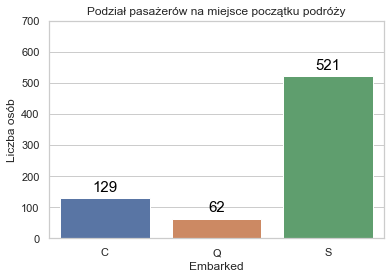

In [33]:
ax=sns.countplot(x=X_train.Embarked.sort_values());
ax.set(ylim=(0, 700))
ax.set_title('Podział pasażerów na miejsce początku podróży')
ax.set(ylabel="Liczba osób")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+110), ha='center', va='top', color='black', size=15)
plt.show()

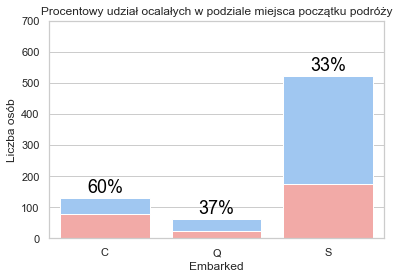

In [34]:
przezycie_od_zameldowania=X_train[['Survived','Embarked']].groupby('Embarked').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_zameldowania.index, y=przezycie_od_zameldowania.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 700))
ax.set_title('Procentowy udział ocalałych w podziale miejsca początku podróży')
i=0
for p in ax.patches:
    procent=przezycie_od_zameldowania['Survived'].iloc[i,0]/przezycie_od_zameldowania['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
    i=i+1
ax = sns.barplot(x=przezycie_od_zameldowania.index, y=przezycie_od_zameldowania.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

Przed analizą powyższych wykresów dotyczących miejsca rozpoczęcia podróży warto znać kolejność ich wystąpienia. Pierwszym odwiedzonym przez Titanic miejscem było Southampton (S), następnie statek odwiedził Cherbourg (C), a ostatnim przystankiem przed katastrofą było Queenstown (Q). Widzimy zatem, że zdecydowana większość pasażerów ze zbioru treningowego podróżowała od samego początku rejsu statku. Ta sama grupa wykazała się również najwyższą śmiertelnością (67%). Ciężko doszukiwać się tutaj zależności między czasem wejścia na pokład a śmiertelnością, gdyż odsetek ocalałych w środkowym momencie jest zdecydowanie wyższy od dwóch pozostałych. Nie przekreśla to jednak jeszcze przydatności tej zmiennej w predykcji. 

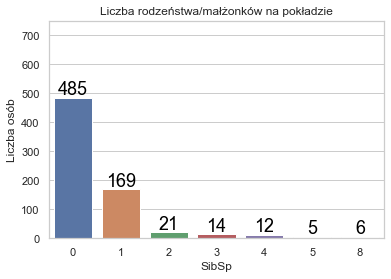

In [35]:
ax=sns.countplot(x=X_train.SibSp);
ax.set(ylim=(0, 750))
ax.set(ylabel="Liczba osób")
ax.set_title('Liczba rodzeństwa/małżonków na pokładzie')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
plt.show()

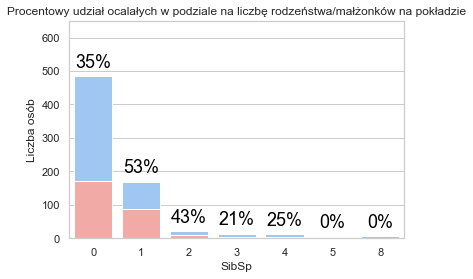

In [36]:
przezycie_od_rodzenstwa=X_train[['Survived','SibSp']].groupby('SibSp').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_rodzenstwa.index, y=przezycie_od_rodzenstwa.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 650))
ax.set_title('Procentowy udział ocalałych w podziale na liczbę rodzeństwa/małżonków na pokładzie')
i=0
for p in ax.patches:
    procent=przezycie_od_rodzenstwa['Survived'].iloc[i,0]/przezycie_od_rodzenstwa['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
    i=i+1
ax = sns.barplot(x=przezycie_od_rodzenstwa.index, y=przezycie_od_rodzenstwa.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

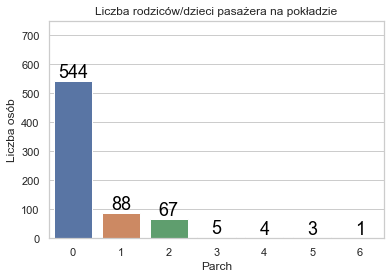

In [37]:
ax=sns.countplot(x=X_train.Parch);
ax.set(ylim=(0, 750))
ax.set(ylabel="Liczba osób")
ax.set_title('Liczba rodziców/dzieci pasażera na pokładzie')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
plt.show()

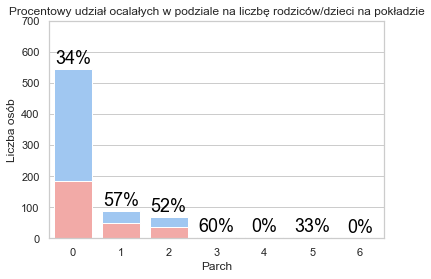

In [38]:
przezycie_od_rodzicow=X_train[['Survived','Parch']].groupby('Parch').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_rodzicow.index, y=przezycie_od_rodzicow.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 700))
ax.set_title('Procentowy udział ocalałych w podziale na liczbę rodziców/dzieci na pokładzie')
i=0
for p in ax.patches:
    procent=przezycie_od_rodzicow['Survived'].iloc[i,0]/przezycie_od_rodzicow['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
    i=i+1
ax = sns.barplot(x=przezycie_od_rodzicow.index, y=przezycie_od_rodzicow.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

Zmienne 'SibSp' i 'Parch' oznaczające kolejno liczbę rodzeństwa/małżonków oraz liczbę rodziców/dzieci pasażera na pokładzie są dość kłopotliwe w użyciu. Pierwszym kłopotem jest barnie tylko rodziców, pomija się tutaj innych opiekunów, np. ciotki, dziadków czy nianie. Drugim kłopotem jest zrównanie ze sobą dość różnych ról: nie spodziewamy się więcej niż dwóch rodziców, ale może być więcej niż dwoje dzieci danego pasażera. Podobnie z parą rodzeństwo i małżonkowie. Z tego też powodu powstała zmienna 'Family', która jest sumą tych dwóch zmiennych - wtedy dziecku będzie odpowiadała suma liczby rodziców i rodzeństwa na pokładzie, a dorosłemu suma małżonka i liczby dzieci. 

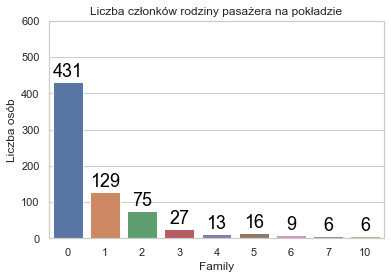

In [39]:
ax=sns.countplot(x=X_train.Family);
ax.set(ylim=(0, 600))
ax.set(ylabel="Liczba osób")
ax.set_title('Liczba członków rodziny pasażera na pokładzie')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+110), ha='center', va='top', color='black', size=18)
plt.show()

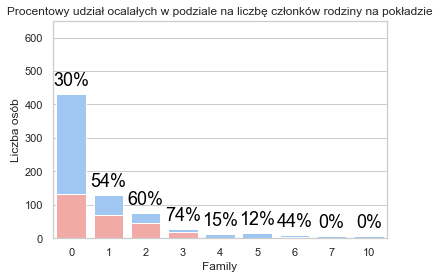

In [40]:
przezycie_od_rodziny=X_train[['Survived','Family']].groupby('Family').agg(['sum','count'])

ax = plt.subplots()
ax = sns.barplot(x=przezycie_od_rodziny.index, y=przezycie_od_rodziny.Survived["count"], color="#92C6FF")
ax.set(ylim=(0, 650))
ax.set_title('Procentowy udział ocalałych w podziale na liczbę członków rodziny na pokładzie')
i=0
for p in ax.patches:
    procent=przezycie_od_rodziny['Survived'].iloc[i,0]/przezycie_od_rodziny['Survived'].iloc[i,1]
    ax.annotate(f'\n{int(round(procent*100,0))}'+"%", (p.get_x()+0.4, p.get_height()+130), ha='center', va='top', color='black', size=18)
    i=i+1
ax = sns.barplot(x=przezycie_od_rodziny.index, y=przezycie_od_rodziny.Survived["sum"], color="#FF9F9A")
  

ax.set(ylabel="Liczba osób")
  

plt.show()

Z drugiego wykresu widzimy ciekawy trend. Procent ocalałych rośnie w przedziale 0-3, a później się załamuje. Niestety dużych rodzin jest bardzo mało w naszym zbiorze treningowym, więc wspomniane załamanie jest dość niepewne, tak samo jak wysoka przeżywalność dla grupy o rodzinie z licznością równą 3. 

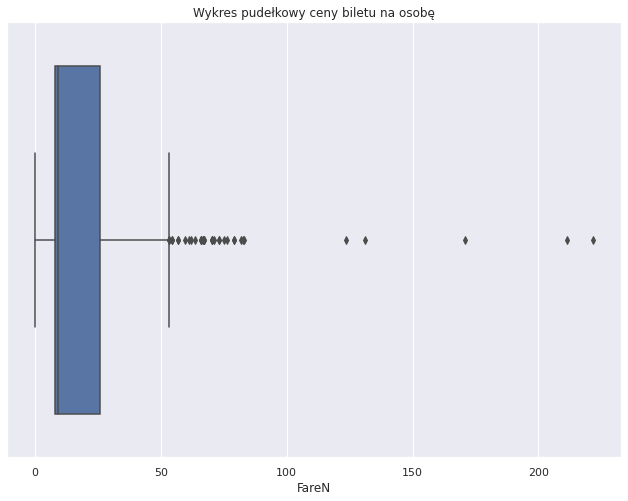

In [41]:
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.boxplot(x=X_train["FareN"])
ax.set_title('Wykres pudełkowy ceny biletu na osobę')
sns.reset_orig()

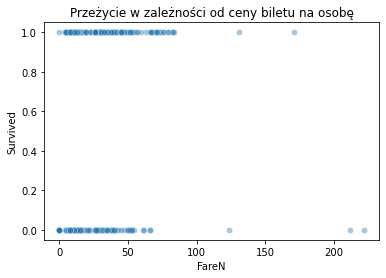

In [42]:
ax = sns.scatterplot(x='FareN', y='Survived', data=X_train, alpha=0.4)
ax.set_title('Przeżycie w zależności od ceny biletu na osobę');
plt.show()

Zmienna 'FareN' okazuje się posiadać dużo wartości odstających. Możemy tutaj zaobserwować asymetrię prawostronną, gdzie mediana obserwacji jest bardzo blisko pierwszego kwartylu w stosunku do trzeciego kwartylu. Drugi wykres dotyczący tej zmiennej przedstawia punkty w taki sposób, że im więcej obserwacji znajduje się w danym miejscu, tym wyraźniejszy punkt. Pierwszą wyróżniającą się rzeczą jest wyraźny punkt (0,0) i blady punkt (0,1). oznacza to, że dużo więcej osób z darmowym biletem zginęło niż przeżyło. Takimi osobami zapewne była obsługa statku. Drugą wyróżniającą się rzeczą jest różnica w długościach linii utworzonych przez punkty w grupach wyznaczonych przez wartość zmiennej 'Survived'. Dla ocalałych ta linia jest trochę dłuższa niż dla ofiar, co oznacza, że od pewnej ceny biletu ludzie mieli większe szanse na przeżycie. 

# Modelowanie predykcyjne

Użyjemy trzech różnych modeli predykcyjnych korzystających z drzew decyzyjnych. Pierwszym będzie jeden z wariantów boostingu - XGboost.  Drugim podejściem będzie standardowy las losowy. Trzecią metodą będzie gradient boosting (GBM). Przed przystąpieniem do modelowania zamienimy jeszcze zmienne kategoryczne na kodowanie metodą "dummy". Następnie za pomocą kroswalidacji oraz losowego przeszukiwania siatki parametrów dobierzemy po jednym modelu z każdej metody. Wyniki porównamy ze sobą pod względem accuracy i indeksu Giniego. 

In [43]:
dummy_cols = ["Pclass","Sex",'Embarked']

X_train=pd.get_dummies(X_train,columns=dummy_cols,drop_first=True)

In [44]:
X_test=pd.get_dummies(X_test,columns=dummy_cols,drop_first=True)

In [45]:
paramsXG = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5,1, 5],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'max_depth': [4, 5,6,7],
        'reg_lambda' : [1,2,3],
        'eta' : [0.3,0.6]
        }

In [46]:
XGbClass1 = XGBClassifier(n_estimators=1000, learning_rate=0.01, random_state=1001, objective='binary:logistic', eval_metric='auc',use_label_encoder=False) 

In [47]:
folds = 5
param_comb = 150

random_search = RandomizedSearchCV(XGbClass1, paramsXG, n_jobs=1, cv=folds, n_iter=param_comb,random_state=1001)
X_train1=X_train[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].copy()
X_train1 = np.ascontiguousarray(X_train1)
y_train = np.ascontiguousarray(y_train)

random_search.fit(X_train1, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best hyperparameters:
{'subsample': 1.0, 'reg_lambda': 1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 5, 'eta': 0.3, 'colsample_bytree': 0.7}


In [48]:
XGbest=XGBClassifier(n_estimators=1000, learning_rate=0.01, subsample= 1,reg_lambda=1,
                      min_child_weight= 5, max_depth= 6, gamma= 5,eta=0.6, colsample_bytree= 1,
                      random_state=1001, objective='binary:logistic', eval_metric='auc',
                      use_label_encoder=False)



X_test1=X_test[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].copy()
X_test1 = np.ascontiguousarray(X_test1)
y_test = np.ascontiguousarray(y_test)
XGbest.fit(X_train1,y_train) 
XGpred = XGbest.predict(X_test1) 
XGtrainpred = XGbest.predict(X_train1) 
acc_XGbest_train = accuracy_score(XGtrainpred,y_train) 
acc_XGbest_test = accuracy_score(XGpred,y_test) 

gini_XGbest_train = 2*roc_auc_score(XGtrainpred,y_train) -1
gini_XGbest_test = 2*roc_auc_score(XGpred,y_test) -1


print("Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła: ", acc_XGbest_train)
print("Wartość accuracy na zbiorze testowym dla tego modelu wyniosła: ", acc_XGbest_test)

print("Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła: ", gini_XGbest_train)
print("Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła: ", gini_XGbest_test)

Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła:  0.8328651685393258
Wartość accuracy na zbiorze testowym dla tego modelu wyniosła:  0.8212290502793296
Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła:  0.6557374205244302
Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła:  0.6425667828106854


In [49]:
RF=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features=None,   n_jobs=1,
                                random_state=42)

In [50]:
RF.fit(X_train1,y_train) 
RFpred = RF.predict(X_test1) 
RFtrainpred = RF.predict(X_train1) 
acc_RFbest_train = accuracy_score(RFtrainpred,y_train) 
acc_RFbest_test = accuracy_score(RFpred,y_test) 

print("Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła: ", acc_RFbest_train)
print("Wartość accuracy na zbiorze testowym dla tego modelu wyniosła: ", acc_RFbest_test)




gini_RFbest_train = 2*roc_auc_score(RFtrainpred,y_train) -1
gini_RFbest_test = 2*roc_auc_score(RFpred,y_test) -1

print("Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła: ", gini_RFbest_train)
print("Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła: ", gini_RFbest_test)

Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła:  0.9859550561797753
Wartość accuracy na zbiorze testowym dla tego modelu wyniosła:  0.8100558659217877
Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła:  0.9730517848164908
Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła:  0.6165795586527294


In [51]:
paramsGBM = {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [2, 3, 4, 5],
        'subsample': [0.9, 1]
        }

In [52]:
GBM1=GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1,random_state=42)

In [53]:
folds = 5
param_comb = 24

random_search = RandomizedSearchCV(GBM1, paramsGBM, n_jobs=1, cv=folds, n_iter=param_comb,random_state=1001)
X_train1=X_train[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].copy()

random_search.fit(X_train1, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best hyperparameters:
{'subsample': 1, 'max_depth': 3, 'learning_rate': 0.1}


In [54]:
GBMbest=GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                              learning_rate=0.1, subsample=1,random_state=42)

GBMbest.fit(X_train1,y_train) 
GBMpred = GBMbest.predict(X_test1) 
GBMtrainpred = GBMbest.predict(X_train1) 
acc_GBMbest_train = accuracy_score(GBMtrainpred,y_train) 
acc_GBMbest_test = accuracy_score(GBMpred,y_test) 

gini_GBMbest_train = 2*roc_auc_score(GBMtrainpred,y_train) -1
gini_GBMbest_test = 2*roc_auc_score(GBMpred,y_test) -1


print("Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła: ", acc_GBMbest_train)
print("Wartość accuracy na zbiorze testowym dla tego modelu wyniosła: ", acc_GBMbest_test)

print("Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła: ", gini_GBMbest_train)
print("Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła: ", gini_GBMbest_test)

Wartość accuracy na zbiorze treiningowym dla tego modelu wyniosła:  0.9058988764044944
Wartość accuracy na zbiorze testowym dla tego modelu wyniosła:  0.8379888268156425
Wartość indeksu Giniego na zbiorze treiningowym dla tego modelu wyniosła:  0.8117904492212638
Wartość indeksu Giniego na zbiorze testowym dla tego modelu wyniosła:  0.6851906158357772


In [55]:
acc_train=[acc_XGbest_train,acc_RFbest_train,acc_GBMbest_train]
acc_test=[acc_XGbest_test,acc_RFbest_test,acc_GBMbest_test]
gini_train=[gini_XGbest_train,gini_RFbest_train,gini_GBMbest_train]
gini_test=[gini_XGbest_test,gini_RFbest_test,gini_GBMbest_test]
pd.DataFrame([acc_train,acc_test,gini_train,gini_test],columns=[['XGbost', 'RF', 'GBM']]).set_index([["accuracy zbioru treningowego", "accuracy zbioru testowego", 'Gini zbioru treningowego', 'Gini zbioru testowego']])

,XGbost,RF,GBM
accuracy zbioru treningowego,0.832865,0.985955,0.905899
accuracy zbioru testowego,0.821229,0.810056,0.837989
Gini zbioru treningowego,0.655737,0.973052,0.811790
Gini zbioru testowego,0.642567,0.616580,0.685191


Z rozważanych modeli najlepszym okazał się boosting GBM. Uzyskał on najwyższą wartość accuracy na zbiorze treningowym równą 0.837989 oraz najlepszy indeks Giniego równy 0.685191. Model ten jednak wykazał się lekkim przeuczeniem - wydać wyraźną różnicę w accuracy między zbiorami treningowym i testowym. Na drugim miejscu, pod względem jakości predykcji, znalazł się XGboost z niewiele mniejszymi wskaźnikami accuracy i Gini. Model ten osiągnął porównywalne wyniki na zbiorze uczącym i testowym. Najgorzej wypadł model lasu losowego. Osiągnął on trochę gorsze wyniki pod względem accuracy i Gini od pozostałych. Wykazał się on również bardzo dużym przeuczeniem. 
Ciekawą informacją może okazać się ważność zmiennych według modelu. Poniżej znajdują się 3 wykresy - po jednym dla każdej metody. Opisują one średnie spadki Gini Impurity dla każdej zmiennej w każdym modelu. 

In [56]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return(fi_df['feature_names'])

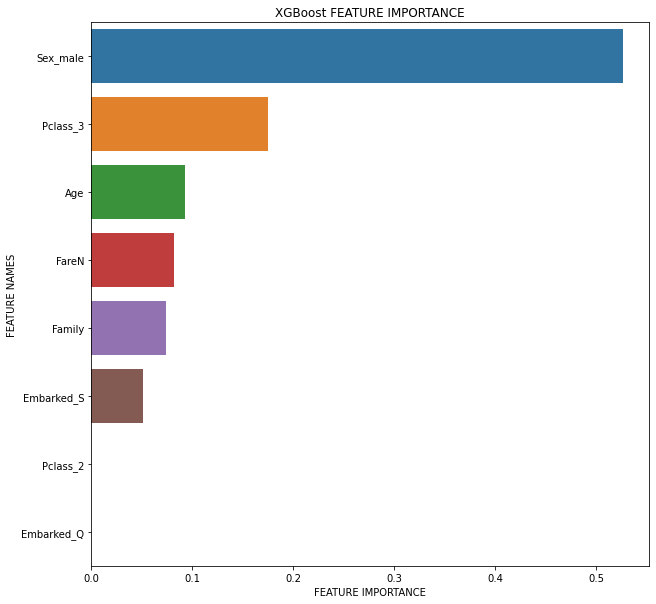

In [57]:
plot_feature_importance(XGbest.feature_importances_,X_test[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].columns,'XGBoost');

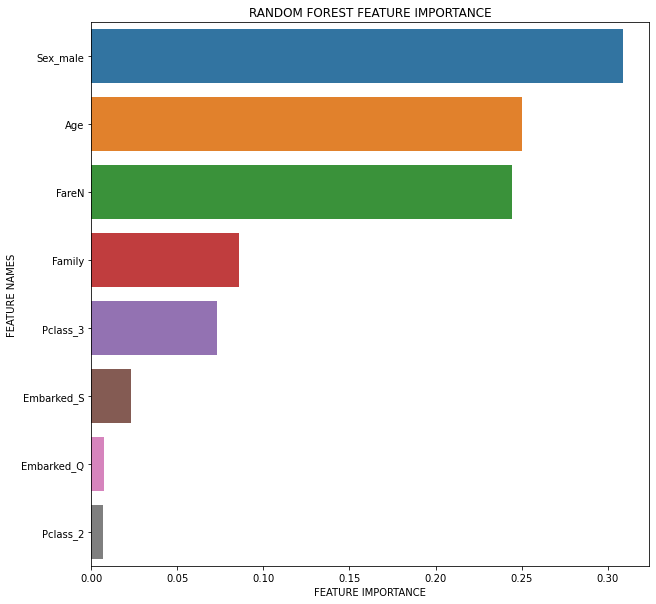

In [58]:
plot_feature_importance(RF.feature_importances_,X_test[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].columns,'RANDOM FOREST');

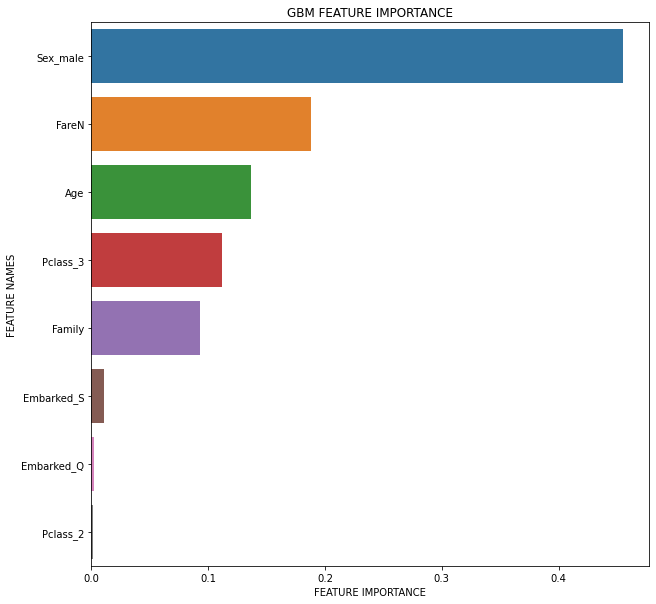

In [59]:
plot_feature_importance(GBMbest.feature_importances_,X_test[['Age','FareN','Family','Pclass_2','Pclass_3', "Sex_male","Embarked_Q","Embarked_S"]].columns,'GBM');

Wszystkie wykresy zdradzają to, czego się spodziewaliśmy. Najważniejszą zmienną okazała się płeć. Drugie miejsce jest różne dla każdej metody. GBM wybrał koszt biletu na osobę, XGboost wskazał indykator klasy trzeciej, a las losowy wziął wiek pasażera. Jednakże wszystkie te zmienne okazały się dość istotne bez względu na model. Trochę mniej istotna okazała się zmienna opisująca liczbę członków rodziny na pokładzie, a praktycznie bez znaczenia były indykatory klasy drugiej i miejsc rozpoczęcia podróży. 


Na koniec spójrzmy jeszcze na macierze konfuzji każdej z metod. 

### Xgboost

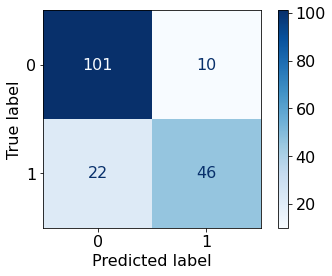

In [60]:
plt.rcParams.update({'font.size': 16})

plot_confusion_matrix(XGbest, X_test1, y_test,
                                 cmap=plt.cm.Blues);

### Random Forest

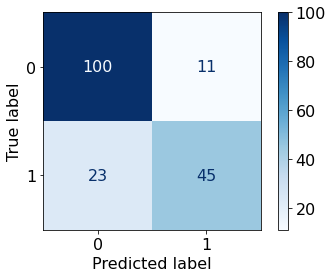

In [61]:
plot_confusion_matrix(RF, X_test1, y_test,
                                 cmap=plt.cm.Blues);

### GBM

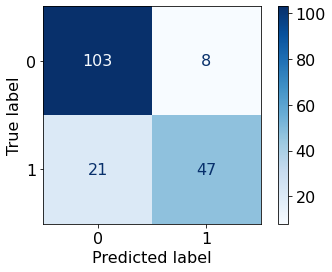

In [62]:
plot_confusion_matrix(GBMbest, X_test1, y_test,
                                 cmap=plt.cm.Blues);

Wartości False Positive Rate, czyli iloraz liczby błędnie przewidzianych ofiar i liczby wszystkich ocalałych, dla XGboost, RF i GBM to kolejno 0.09, 0.1 i 0.07. Wartości False Negative Rate, czyli iloraz błędnie przewidzianych ocalałych i wszystkich ofiar, dla XGboost, RF i GBM to kolejno 0.32, 0.34 i 0.31. Widzimy zatem, że modele dużo lepiej poradziły sobie z odgadnięciem ocalałych niż ofiar. 
 

Podsumowując, metody zadziałały bardzo podobnie. Metoda GBM wypadła tutaj najlepiej, oba wskaźniki błędnych predykcji są najniższe. Po drugiej stronie jest las losowy, który miał najwyższe wskaźniki błędów. Najważniejszą zmienną okazała się płeć pasażera, potem cena biletu za osobę i wiek pasażera. Wynik accuracy na poziomie 83.8% wydaje się tutaj zadowalający. 